https://gymnasium.farama.org/environments/classic_control/pendulum/

In [1]:
import gymnasium as gym
import random
import collections
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
#Hyperparameters
#actor와 critic의 learning rate를 다르게 주는게 학습 안정화에 좋음
lr_mu        = 0.0005
lr_q         = 0.001
gamma        = 0.99
batch_size   = 32
buffer_limit = 50000
tau          = 0.005 # for target network soft update

In [3]:
class ReplayBuffer():
    def __init__(self):
        self.buffer = collections.deque(maxlen=buffer_limit)

    def put(self, transition):
        self.buffer.append(transition)
    
    def sample(self, n):
        mini_batch = random.sample(self.buffer, n)
        s_lst, a_lst, r_lst, s_prime_lst, done_mask_lst = [], [], [], [], []

        for transition in mini_batch:
            s, a, r, s_prime, done = transition
            s_lst.append(s)
            a_lst.append([a])
            r_lst.append([r])
            s_prime_lst.append(s_prime)
            done_mask = 0.0 if done else 1.0 
            done_mask_lst.append([done_mask])
        
        return torch.tensor(s_lst, dtype=torch.float), torch.tensor(a_lst, dtype=torch.float), \
                torch.tensor(r_lst, dtype=torch.float), torch.tensor(s_prime_lst, dtype=torch.float), \
                torch.tensor(done_mask_lst, dtype=torch.float)
    
    def size(self):
        return len(self.buffer)


Action Space

Box(-2.0, 2.0, (1,), float32)

Observation Space

Box([-1. -1. -8.], [1. 1. 8.], (3,), float32)

In [4]:
# actor -> input : state , output : action
class MuNet(nn.Module):
    def __init__(self):
        super(MuNet, self).__init__()
        self.fc1 = nn.Linear(3, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc_mu = nn.Linear(64, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        # torch.tanh() -> [-1, 1]
        # Multipled by 2 because the action space of the Pendulum-v1 is [-2,2]
        # mu = torch.tanh(self.fc_mu(x))*2
        # btw, tanh has an issue about gradient vanishing when the prior network is simple mlp
        mu = torch.clamp(self.fc_mu(x), -2., 2.)
        return mu

In [5]:
class QNet(nn.Module):
    def __init__(self):
        super(QNet, self).__init__()
        self.fc_s = nn.Linear(3, 64) #state subnetwork
        self.fc_a = nn.Linear(1,64) #action subnetwork
        self.fc_q = nn.Linear(128, 32)  
        self.fc_out = nn.Linear(32,1)

    def forward(self, x, a):
        h1 = F.relu(self.fc_s(x)) #state
        h2 = F.relu(self.fc_a(a)) #action
        cat = torch.cat([h1,h2], dim=1)
        q = F.relu(self.fc_q(cat))
        q = self.fc_out(q) #state action value
        return q


In [6]:
class OrnsteinUhlenbeckNoise:
    def __init__(self, mu):
        self.theta, self.dt, self.sigma = 0.1, 0.01, 0.1
        self.mu = mu
        self.x_prev = np.zeros_like(self.mu)

    def __call__(self):
        x = self.x_prev + self.theta * (self.mu - self.x_prev) * self.dt + \
                self.sigma * np.sqrt(self.dt) * np.random.normal(size=self.mu.shape)
        self.x_prev = x
        return x

Difference between detach(), detach()_, with torch.no_grad()

with torch.no_grad() won’t track the wrapped operations by Autograd, so that intermediate tensors won’t be stored, which would be needed for the backward pass.
That being said, you should not wrap the complete forward pass in this block during training, as you won’t be able to calculate the gradients.

detach() operates on a tensor and returns the same tensor, which will be detached from the computation graph at this point, so that the backward pass will stop at this point.
detach_() is the inplace operation of detach().

https://discuss.pytorch.org/t/what-the-difference-between-detach-detach-and-with-torch-no-grad-in-our-training-phase/64390

In [7]:
def train(mu, mu_target, q, q_target, memory, q_optimizer, mu_optimizer):
    s,a,r,s_prime,done_mask  = memory.sample(batch_size)
    
    target = r + gamma * q_target(s_prime, mu_target(s_prime)) * done_mask
    q_loss = F.smooth_l1_loss(q(s,a), target.detach())
    q_optimizer.zero_grad()
    q_loss.backward()
    q_optimizer.step()
    
    # mu loss
    mu_loss = -q(s,mu(s)).mean()
    mu_optimizer.zero_grad()
    mu_loss.backward()
    mu_optimizer.step()

# soft_update1,2번 시간 차이 확인해보기

difference of state_dict() and parameters()
: state_dict returns a dictionary containing a whole state of the module. It contains not just the call to parameters but also buffers, etc.


+) the attribute requires_grad of trainable tensors in net.parameters() is True, while False in net.state_dict()


https://stackoverflow.com/questions/54746829/pytorch-whats-the-difference-between-state-dict-and-parameters

In [8]:
def soft_update2(net, net_target):
    for param_target, param in zip(net_target.parameters(), net.parameters()):
        param_target.data.copy_(param_target.data * (1.0 - tau) + param.data * tau)

def soft_update(net, net_target):
    target_sd = net_target.state_dict()
    sd = net.state_dict()
    for key in target_sd:
        target_sd[key] = sd[key]*tau + target_sd[key]*(1 - tau)
    net_target.load_state_dict(target_sd)

In [9]:
env = gym.make('Pendulum-v1', max_episode_steps=200, autoreset=True)
memory = ReplayBuffer()

q, q_target = QNet(), QNet()
q_target.load_state_dict(q.state_dict())
mu, mu_target = MuNet(), MuNet()
mu_target.load_state_dict(mu.state_dict())

score = 0.0
print_interval = 20

mu_optimizer = optim.Adam(mu.parameters(), lr=lr_mu)
q_optimizer  = optim.Adam(q.parameters(), lr=lr_q)
ou_noise = OrnsteinUhlenbeckNoise(mu=np.zeros(1))


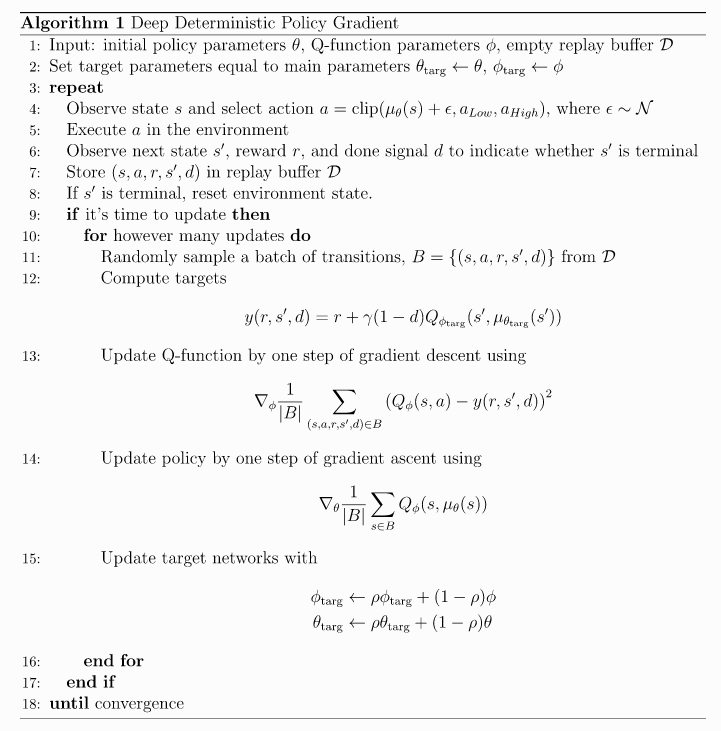

In [10]:
for n_epi in range(2000):
    s, _ = env.reset()
    done = False

    count = 0
    # episode 길이가 200이 되거나 done이 True가 되면 종료
    while count < 200 and not done:
        a = mu(torch.from_numpy(s).float()) #deterministic policy
        a = a.item()# + ou_noise()[0] # a는 mu net의 output이라서 그냥 그대로 buffer에 넣어주면 에러가 발생함 -> .item()으로 detach
        s_prime, r, done, truncated, info = env.step([a])
        memory.put((s,a,r/100.0,s_prime,done))
        score +=r
        s = s_prime
        count += 1
            
    if memory.size()>2000:
        for i in range(10):
            # batch size를 줄이고 업데이트 횟수를 늘림 - For More exploration,,,이라고 생각
            # 결국 같은 배치사이즈더라도 더 많이 업데이트 하기 때문!
            train(mu, mu_target, q, q_target, memory, q_optimizer, mu_optimizer)
            soft_update(mu, mu_target)
            soft_update(q,  q_target)
    
    if n_epi%print_interval==0 and n_epi!=0:
        print("# of episode :{}, avg score : {:.1f}".format(n_epi, score/print_interval))
        score = 0.0

env.close()

/tmp/ipykernel_125415/1136159539.py:21: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646756402876/work/torch/csrc/utils/tensor_new.cpp:210.)
  return torch.tensor(s_lst, dtype=torch.float), torch.tensor(a_lst, dtype=torch.float), \


# of episode :20, avg score : -1379.1
# of episode :40, avg score : -1578.9
# of episode :60, avg score : -1590.2
# of episode :80, avg score : -1585.0
# of episode :100, avg score : -1594.7
# of episode :120, avg score : -1512.7
# of episode :140, avg score : -1569.5
# of episode :160, avg score : -1563.1
# of episode :180, avg score : -1531.2
# of episode :200, avg score : -1561.9
# of episode :220, avg score : -1534.6
# of episode :240, avg score : -1653.5
# of episode :260, avg score : -1585.3
# of episode :280, avg score : -1507.4
# of episode :300, avg score : -1405.5
# of episode :320, avg score : -1419.7
# of episode :340, avg score : -1338.0
# of episode :360, avg score : -1238.1
# of episode :380, avg score : -1070.9
# of episode :400, avg score : -1089.0
# of episode :420, avg score : -1099.1
# of episode :440, avg score : -1204.0
# of episode :460, avg score : -1295.8
# of episode :480, avg score : -1295.5
# of episode :500, avg score : -1011.1
# of episode :520, avg score 